In [14]:
from rdkit import Chem

Example molecule. We'll need the atom indices.

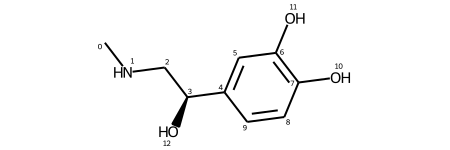

In [15]:
mol = Chem.MolFromSmiles("CNC[C@@H](C1=CC(=C(C=C1)O)O)O")
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.drawOptions.useBWAtomPalette()

mol

Our model requires explicit hydrogens. If you wish to investigate terms that include hydrogens, you will need those indices too. Drawings can become a little crowded.

We must "sanitize" our molecule, otherwise RDKit does not make chirality or cis/trans notation available.

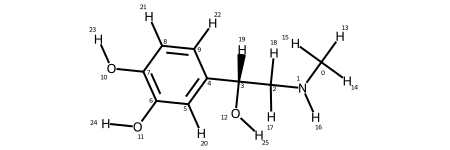

In [16]:
molh = Chem.AddHs(mol)
Chem.SanitizeMol(molh)
molh

Our model uses a dictionary. Build a compatible version here.

In [17]:
import database
import torch

def dictionary(mol):
    x = database.example(mol)

    return {
        'atoms': torch.tensor(x['atoms'], dtype=int),
        'bonds': torch.tensor(x['bonds'], dtype=int),
        'angles': torch.tensor(x['angles'], dtype=int),
        'propers': torch.tensor(x['propers'], dtype=int),
        'pairs': torch.tensor(x['pairs'], dtype=int),
        'tetras': torch.tensor(x['tetras'], dtype=int),
        'cistrans': torch.tensor(x['cistrans'], dtype=int)
    }

x = dictionary(molh)

We'll need to load the checkpoint of the model we are interested in

In [18]:
model = torch.load("checkpoints/qmugs.pt").to("cpu")

Nonbonded components are sorted. We have a couple choices:

1. Reproduce the sorting algorithm
2. Identify the component of interest in its sorted form

The latter is implemented below

In [19]:

sigma_sched = torch.tensor([0.0,1.0,4.0])

class bond_probe:
    def __init__(self, xt, sigma_sched, atom0, atom1):
        for b in xt['bonds']:
            if b[0] == atom0 and b[1] == atom1:
                self.dl, self.sigma, self.correction = model.probe_bond( xt, sigma_sched, b[0], b[1] )
                break
            if b[0] == atom1 and b[1] == atom0:
                self.dl, self.sigma, self.correction = model.probe_bond( xt, sigma_sched, b[0], b[1] )
                self.correction = self.correction[:,:,(1,0)]
                break
        else:
            raise Exception("Bond not found")

        self.dl = self.dl.detach().numpy()
        self.sigma = self.sigma.detach().numpy()
        self.correction = self.correction.detach().numpy()

bonds = bond_probe(x, sigma_sched, 2, 3)

Numerical values are now available for study

Note that the paper and the code have a different sign convention

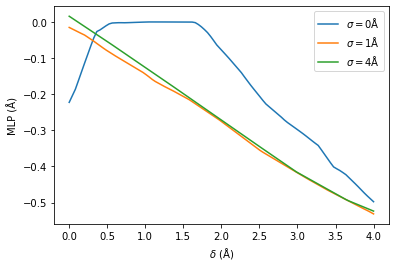

In [20]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.plot(bonds.dl[:,0], -bonds.correction[:,0,0], label="$\sigma = 0$Å")
ax.plot(bonds.dl[:,1], -bonds.correction[:,1,0], label="$\sigma = 1$Å")
ax.plot(bonds.dl[:,2], -bonds.correction[:,2,0], label="$\sigma = 4$Å")
ax.set_xlabel("$\delta$ (Å)")
ax.set_ylabel('MLP (Å)')
ax.legend()
